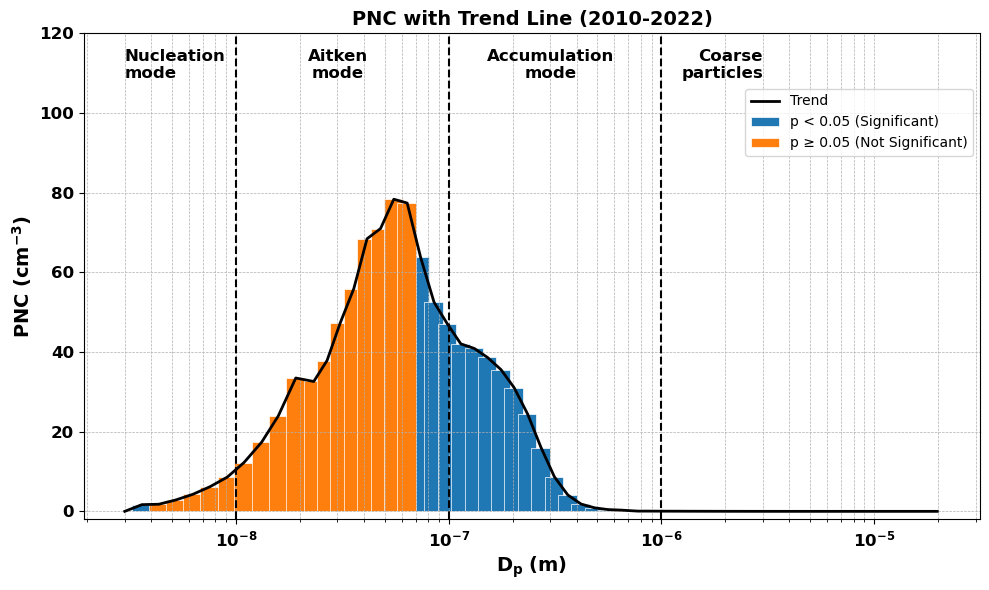

In [1]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====
def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def custom_median(x):
    len_month = days_in_month(x.index)
    return x.median() if len(x) >= 0.75 * len_month else np.nan

def effective_sample_size(x, nlags=12):
    """Calculate effective sample size while avoiding division by zero warnings."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2 or np.all(x == x.iloc[0]):  # constant or too short series
        return 1
    try:
        acfs = acf(x, nlags=nlags, fft=True)[1:]
        ess = n / (1 + 2 * np.sum(acfs))
        return max(ess, 1)
    except Exception:
        return 1

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

# ==== Load and Process Data ====
file_path = '/Users/touqeergill/Desktop/10. PNC (DMPS + APS (2010-2022).xlsx'
df_pnc = pd.read_excel(file_path)

# Parse datetime
df_pnc['datetime'] = pd.to_datetime(df_pnc['datetime'])
df_pnc.set_index('datetime', inplace=True)

# Monthly resampling
resampled_pnc = df_pnc.resample('M').agg(custom_median)
resampled_pnc_low = df_pnc.resample('M').quantile(0.25)
resampled_pnc_up = df_pnc.resample('M').quantile(0.75)

# ==== Compute Trend Statistics ====
x_dates = resampled_pnc.index
x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
x_num = x_num.to_numpy()

trend_stats_pnc = []
for col in resampled_pnc.columns:
    y_main = resampled_pnc[col]
    y_low = resampled_pnc_low[col]
    y_up = resampled_pnc_up[col]

    mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
    if np.sum(mask) < 12:
        continue

    x_vals = x_dates[mask]
    y_vals = y_main[mask].to_numpy(dtype='float64')
    x_num_masked = x_num[mask]

    try:
        tau, p_value = modified_mk_test(x_num_masked, y_vals)
        slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
        slope_unc = (slope_hi - slope_lo) / 2
        median_y = np.median(y_vals)
        slope_yr = slope * 365.25
        slope_unc_yr = slope_unc * 365.25
        rel_trend = (slope_yr / abs(median_y)) * 100 if median_y != 0 else 0
        rel_unc = (slope_unc_yr / abs(median_y)) * 100 if median_y != 0 else 0

        trend_stats_pnc.append({
            'Bin': float(col),
            'PNC': median_y,
            'Slope (unit/yr)': slope_yr,
            '± Slope Uncertainty': slope_unc_yr,
            'Relative Trend (%/yr)': rel_trend,
            '± Relative Uncertainty': rel_unc,
            'p-value': p_value
        })
    except Exception:
        continue

trend_df_pnc = pd.DataFrame(trend_stats_pnc)

# ==== Plot ====
particle_sizes = trend_df_pnc['Bin'].to_numpy()
pnc_values = trend_df_pnc['PNC'].to_numpy()
p_values = trend_df_pnc['p-value'].to_numpy()

# Significance categories
significant = p_values < 0.05
not_significant = p_values >= 0.05

# Colors
color_significant = '#1f77b4'
color_not_significant = '#ff7f0e'

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for PNC
ax.bar(particle_sizes[significant], pnc_values[significant],
       width=particle_sizes[significant] * 0.2, color=color_significant,
       edgecolor='white', linewidth=0.5, label='p < 0.05 (Significant)')
ax.bar(particle_sizes[not_significant], pnc_values[not_significant],
       width=particle_sizes[not_significant] * 0.2, color=color_not_significant,
       edgecolor='white', linewidth=0.5, label='p ≥ 0.05 (Not Significant)')

# Black line connecting bar tops
ax.plot(particle_sizes, pnc_values, color='black', linewidth=2, label='Trend')

# ==== Y-axis range (adjustable) ====
y_min = -2     # Set minimum y-axis value
y_max = 120    # Set maximum y-axis value (adjustable)
ax.set_ylim(y_min, y_max)

# Formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ $\mathbf{(m)}$', fontsize=14)
ax.set_ylabel(r'PNC (cm$^{\mathbf{-3}}$)', fontsize=14, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mode boundaries
mode_boundaries = [1e-8, 1e-7, 1e-6]
for boundary in mode_boundaries:
    ax.axvline(x=boundary, color='black', linestyle='--')

# ==== Mode labels (multi-line, centered inside plot) ====
y_label_pos = y_max * 0.90
ax.text(3e-9, y_label_pos, 'Nucleation\nmode', fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(3e-8, y_label_pos, 'Aitken\nmode', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.text(3e-7, y_label_pos, 'Accumulation\nmode', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.text(3e-6, y_label_pos, 'Coarse\nparticles', fontsize=12, fontweight='bold', ha='right', va='bottom')

# Title and legend
ax.set_title('PNC with Trend Line (2010-2022)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.90))  # moved legend down

# Bold ticks
ax.tick_params(axis='both', labelsize=12)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

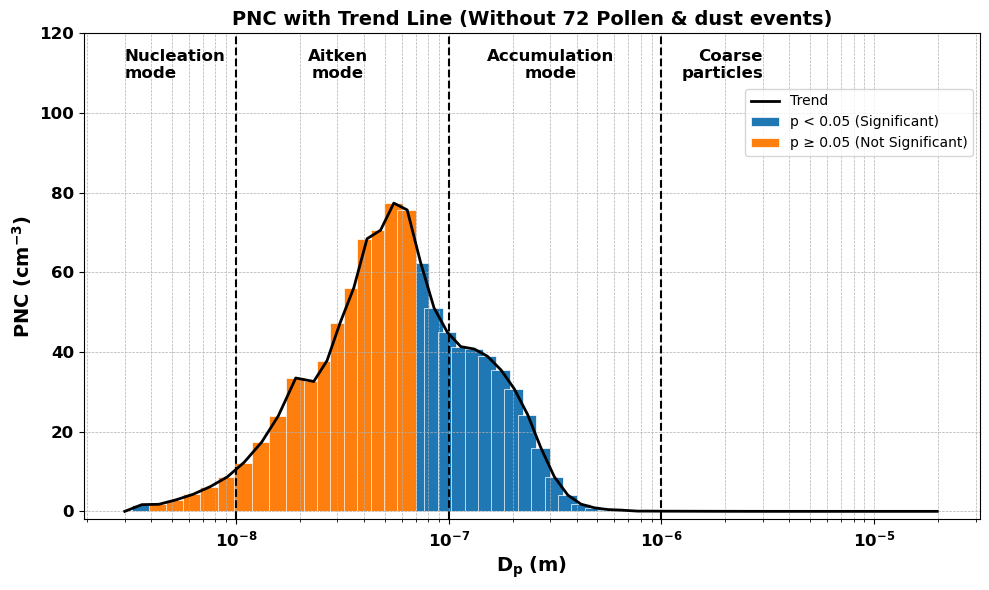

In [2]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====
def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def custom_median(x):
    len_month = days_in_month(x.index)
    return x.median() if len(x) >= 0.75 * len_month else np.nan

def effective_sample_size(x, nlags=12):
    """Calculate effective sample size while avoiding division by zero warnings."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2 or np.all(x == x.iloc[0]):  # constant or too short series
        return 1
    try:
        acfs = acf(x, nlags=nlags, fft=True)[1:]
        ess = n / (1 + 2 * np.sum(acfs))
        return max(ess, 1)
    except Exception:
        return 1

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

# ==== Load and Process Data ====
file_path = '/Users/touqeergill/Desktop/10. PNC Without 72 Pollen and dust events.xlsx'
df_pnc = pd.read_excel(file_path)

# Parse datetime
df_pnc['datetime'] = pd.to_datetime(df_pnc['datetime'])
df_pnc.set_index('datetime', inplace=True)

# Monthly resampling
resampled_pnc = df_pnc.resample('M').agg(custom_median)
resampled_pnc_low = df_pnc.resample('M').quantile(0.25)
resampled_pnc_up = df_pnc.resample('M').quantile(0.75)

# ==== Compute Trend Statistics ====
x_dates = resampled_pnc.index
x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
x_num = x_num.to_numpy()

trend_stats_pnc = []
for col in resampled_pnc.columns:
    y_main = resampled_pnc[col]
    y_low = resampled_pnc_low[col]
    y_up = resampled_pnc_up[col]

    mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
    if np.sum(mask) < 12:
        continue

    x_vals = x_dates[mask]
    y_vals = y_main[mask].to_numpy(dtype='float64')
    x_num_masked = x_num[mask]

    try:
        tau, p_value = modified_mk_test(x_num_masked, y_vals)
        slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
        slope_unc = (slope_hi - slope_lo) / 2
        median_y = np.median(y_vals)
        slope_yr = slope * 365.25
        slope_unc_yr = slope_unc * 365.25
        rel_trend = (slope_yr / abs(median_y)) * 100 if median_y != 0 else 0
        rel_unc = (slope_unc_yr / abs(median_y)) * 100 if median_y != 0 else 0

        trend_stats_pnc.append({
            'Bin': float(col),
            'PNC': median_y,
            'Slope (unit/yr)': slope_yr,
            '± Slope Uncertainty': slope_unc_yr,
            'Relative Trend (%/yr)': rel_trend,
            '± Relative Uncertainty': rel_unc,
            'p-value': p_value
        })
    except Exception:
        continue

trend_df_pnc = pd.DataFrame(trend_stats_pnc)

# ==== Plot ====
particle_sizes = trend_df_pnc['Bin'].to_numpy()
pnc_values = trend_df_pnc['PNC'].to_numpy()
p_values = trend_df_pnc['p-value'].to_numpy()

# Significance categories
significant = p_values < 0.05
not_significant = p_values >= 0.05

# Colors
color_significant = '#1f77b4'
color_not_significant = '#ff7f0e'

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for PNC
ax.bar(particle_sizes[significant], pnc_values[significant],
       width=particle_sizes[significant] * 0.2, color=color_significant,
       edgecolor='white', linewidth=0.5, label='p < 0.05 (Significant)')
ax.bar(particle_sizes[not_significant], pnc_values[not_significant],
       width=particle_sizes[not_significant] * 0.2, color=color_not_significant,
       edgecolor='white', linewidth=0.5, label='p ≥ 0.05 (Not Significant)')

# Black line connecting bar tops
ax.plot(particle_sizes, pnc_values, color='black', linewidth=2, label='Trend')

# ==== Y-axis range (adjustable) ====
y_min = -2     # Set minimum y-axis value
y_max = 120    # Set maximum y-axis value (adjustable)
ax.set_ylim(y_min, y_max)

# Formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ $\mathbf{(m)}$', fontsize=14)
ax.set_ylabel(r'PNC (cm$^{\mathbf{-3}}$)', fontsize=14, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mode boundaries
mode_boundaries = [1e-8, 1e-7, 1e-6]
for boundary in mode_boundaries:
    ax.axvline(x=boundary, color='black', linestyle='--')

# ==== Mode labels (multi-line, centered inside plot) ====
y_label_pos = y_max * 0.90
ax.text(3e-9, y_label_pos, 'Nucleation\nmode', fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(3e-8, y_label_pos, 'Aitken\nmode', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.text(3e-7, y_label_pos, 'Accumulation\nmode', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.text(3e-6, y_label_pos, 'Coarse\nparticles', fontsize=12, fontweight='bold', ha='right', va='bottom')

# Title and legend
ax.set_title('PNC with Trend Line (Without 72 Pollen & dust events)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.90))  # moved legend down

# Bold ticks
ax.tick_params(axis='both', labelsize=12)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

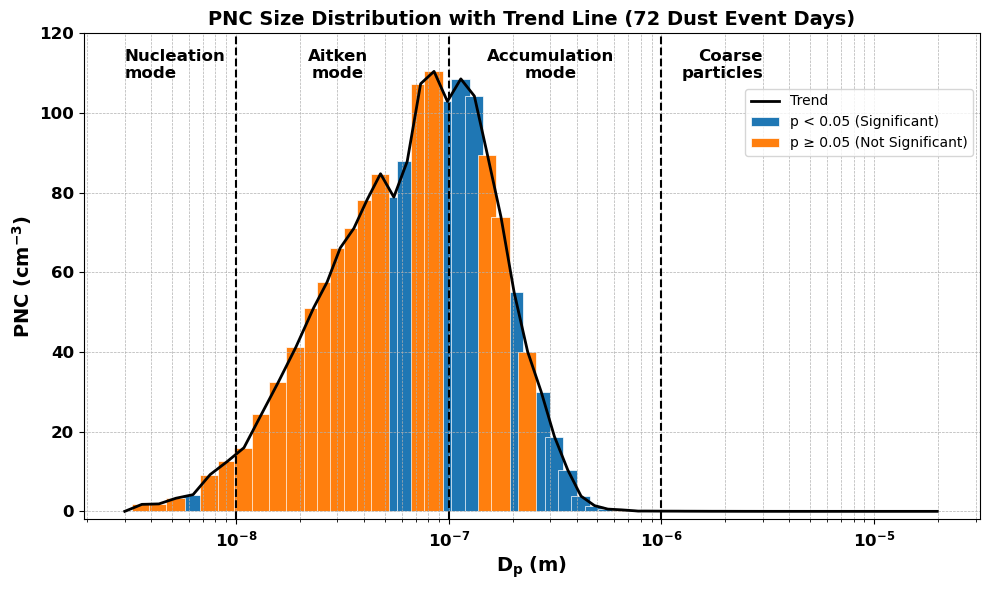

In [3]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====
def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def custom_median(x):
    len_month = days_in_month(x.index)
    return x.median() if len(x) >= 0.75 * len_month else np.nan

def effective_sample_size(x, nlags=12):
    """Calculate effective sample size while avoiding division by zero warnings."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2 or np.all(x == x.iloc[0]):  # constant or too short series
        return 1
    try:
        acfs = acf(x, nlags=nlags, fft=True)[1:]
        ess = n / (1 + 2 * np.sum(acfs))
        return max(ess, 1)
    except Exception:
        return 1

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

# ==== Load and Process Data ====
file_path = '/Users/touqeergill/Desktop/10. PNC 72 Pollen and dust events.xlsx'
df_pnc = pd.read_excel(file_path)

# Parse datetime
df_pnc['datetime'] = pd.to_datetime(df_pnc['datetime'])
df_pnc.set_index('datetime', inplace=True)

# Monthly resampling
resampled_pnc = df_pnc.resample('M').agg(custom_median)
resampled_pnc_low = df_pnc.resample('M').quantile(0.25)
resampled_pnc_up = df_pnc.resample('M').quantile(0.75)

# ==== Compute Trend Statistics ====
x_dates = resampled_pnc.index
x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
x_num = x_num.to_numpy()

trend_stats_pnc = []
for col in resampled_pnc.columns:
    y_main = resampled_pnc[col]
    y_low = resampled_pnc_low[col]
    y_up = resampled_pnc_up[col]

    mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
    if np.sum(mask) < 12:
        continue

    x_vals = x_dates[mask]
    y_vals = y_main[mask].to_numpy(dtype='float64')
    x_num_masked = x_num[mask]

    try:
        tau, p_value = modified_mk_test(x_num_masked, y_vals)
        slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
        slope_unc = (slope_hi - slope_lo) / 2
        median_y = np.median(y_vals)
        slope_yr = slope * 365.25
        slope_unc_yr = slope_unc * 365.25
        rel_trend = (slope_yr / abs(median_y)) * 100 if median_y != 0 else 0
        rel_unc = (slope_unc_yr / abs(median_y)) * 100 if median_y != 0 else 0

        trend_stats_pnc.append({
            'Bin': float(col),
            'PNC': median_y,
            'Slope (unit/yr)': slope_yr,
            '± Slope Uncertainty': slope_unc_yr,
            'Relative Trend (%/yr)': rel_trend,
            '± Relative Uncertainty': rel_unc,
            'p-value': p_value
        })
    except Exception:
        continue

trend_df_pnc = pd.DataFrame(trend_stats_pnc)

# ==== Plot ====
particle_sizes = trend_df_pnc['Bin'].to_numpy()
pnc_values = trend_df_pnc['PNC'].to_numpy()
p_values = trend_df_pnc['p-value'].to_numpy()

# Significance categories
significant = p_values < 0.05
not_significant = p_values >= 0.05

# Colors
color_significant = '#1f77b4'
color_not_significant = '#ff7f0e'

fig, ax = plt.subplots(figsize=(10, 6))

# Bars for PNC
ax.bar(particle_sizes[significant], pnc_values[significant],
       width=particle_sizes[significant] * 0.2, color=color_significant,
       edgecolor='white', linewidth=0.5, label='p < 0.05 (Significant)')
ax.bar(particle_sizes[not_significant], pnc_values[not_significant],
       width=particle_sizes[not_significant] * 0.2, color=color_not_significant,
       edgecolor='white', linewidth=0.5, label='p ≥ 0.05 (Not Significant)')

# Black line connecting bar tops
ax.plot(particle_sizes, pnc_values, color='black', linewidth=2, label='Trend')

# ==== Y-axis range (adjustable) ====
y_min = -2     # Set minimum y-axis value
y_max = 120    # Set maximum y-axis value (adjustable)
ax.set_ylim(y_min, y_max)

# Formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ $\mathbf{(m)}$', fontsize=14)
ax.set_ylabel(r'PNC (cm$^{\mathbf{-3}}$)', fontsize=14, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mode boundaries
mode_boundaries = [1e-8, 1e-7, 1e-6]
for boundary in mode_boundaries:
    ax.axvline(x=boundary, color='black', linestyle='--')

# ==== Mode labels (multi-line, centered inside plot) ====
y_label_pos = y_max * 0.90
ax.text(3e-9, y_label_pos, 'Nucleation\nmode', fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(3e-8, y_label_pos, 'Aitken\nmode', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.text(3e-7, y_label_pos, 'Accumulation\nmode', fontsize=12, fontweight='bold', ha='center', va='bottom')
ax.text(3e-6, y_label_pos, 'Coarse\nparticles', fontsize=12, fontweight='bold', ha='right', va='bottom')

# Title and legend
ax.set_title('PNC Size Distribution with Trend Line (72 Dust Event Days)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.90))  # moved legend down

# Bold ticks
ax.tick_params(axis='both', labelsize=12)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

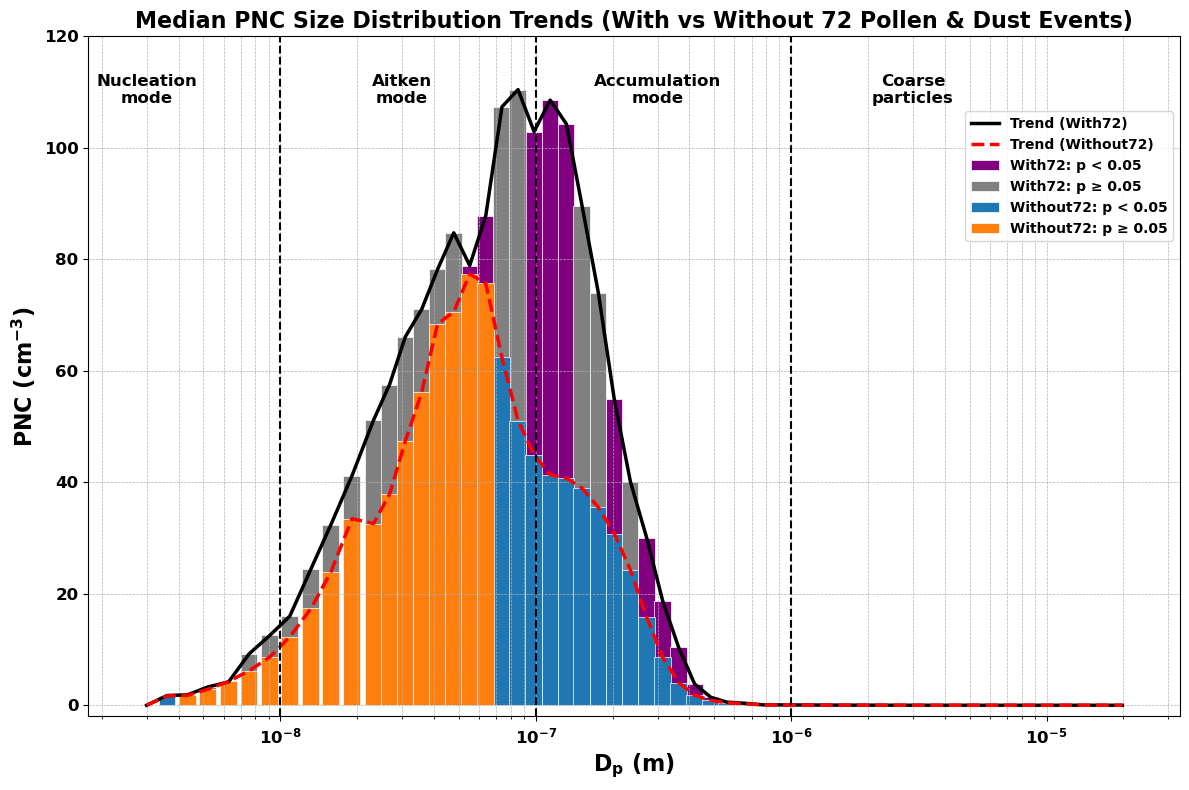

In [4]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====
def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def custom_median(x):
    len_month = days_in_month(x.index)
    return x.median() if len(x) >= 0.75 * len_month else np.nan

def effective_sample_size(x, nlags=12):
    """Calculate effective sample size while avoiding division by zero warnings."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2 or np.all(x == x.iloc[0]):  # constant or too short series
        return 1
    try:
        acfs = acf(x, nlags=nlags, fft=True)[1:]
        ess = n / (1 + 2 * np.sum(acfs))
        return max(ess, 1)
    except Exception:
        return 1

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

def process_file(file_path):
    """Load and process a file, return trend_df"""
    df = pd.read_excel(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Monthly resampling
    resampled = df.resample('M').agg(custom_median)
    resampled_low = df.resample('M').quantile(0.25)
    resampled_up = df.resample('M').quantile(0.75)

    # X for regression
    x_dates = resampled.index
    x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
    x_num = x_num.to_numpy()

    trend_stats = []
    for col in resampled.columns:
        y_main = resampled[col]
        y_low = resampled_low[col]
        y_up = resampled_up[col]

        mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
        if np.sum(mask) < 12:
            continue

        x_num_masked = x_num[mask]
        y_vals = y_main[mask].to_numpy(dtype='float64')

        try:
            tau, p_value = modified_mk_test(x_num_masked, y_vals)
            slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
            slope_unc = (slope_hi - slope_lo) / 2
            median_y = np.median(y_vals)
            slope_yr = slope * 365.25
            slope_unc_yr = slope_unc * 365.25
            rel_trend = (slope_yr / abs(median_y)) * 100 if median_y != 0 else 0
            rel_unc = (slope_unc_yr / abs(median_y)) * 100 if median_y != 0 else 0

            trend_stats.append({
                'Bin': float(col),
                'PNC': median_y,
                'Slope (unit/yr)': slope_yr,
                '± Slope Uncertainty': slope_unc_yr,
                'Relative Trend (%/yr)': rel_trend,
                '± Relative Uncertainty': rel_unc,
                'p-value': p_value
            })
        except Exception:
            continue

    return pd.DataFrame(trend_stats)

# ==== File paths ====
file_with72 = '/Users/touqeergill/Desktop/10. PNC 72 Pollen and dust events.xlsx'
file_without72 = '/Users/touqeergill/Desktop/10. PNC Without 72 Pollen and dust events.xlsx'

# ==== Process both datasets ====
trend_df_with72 = process_file(file_with72)
trend_df_without72 = process_file(file_without72)

# ==== Extract data ====
particle_sizes = trend_df_with72['Bin'].to_numpy()

pnc_with72 = trend_df_with72['PNC'].to_numpy()
p_with72 = trend_df_with72['p-value'].to_numpy()
sig_with72 = p_with72 < 0.05
nonsig_with72 = ~sig_with72

pnc_without72 = trend_df_without72['PNC'].to_numpy()
p_without72 = trend_df_without72['p-value'].to_numpy()
sig_without72 = p_without72 < 0.05
nonsig_without72 = ~sig_without72

# ==== Colors ====
pval_colors = {
    'with_sig': '#800080',       # Purple for With72: p < 0.05
    'with_nonsig': '#808080',    # Grey for With72: p ≥ 0.05
    'without_sig': '#1f77b4',    # Blue for Without72: p < 0.05
    'without_nonsig': '#ff7f0e'  # Orange for Without72: p ≥ 0.05
}

# ==== Plot ====
fig, ax = plt.subplots(figsize=(12, 8))

# Bars: With72
bar_width = particle_sizes * 0.15
ax.bar(particle_sizes[sig_with72], pnc_with72[sig_with72],
       width=bar_width[sig_with72], color=pval_colors['with_sig'],
       edgecolor='white', linewidth=0.5, label='With72: p < 0.05')
ax.bar(particle_sizes[nonsig_with72], pnc_with72[nonsig_with72],
       width=bar_width[nonsig_with72], color=pval_colors['with_nonsig'],
       edgecolor='white', linewidth=0.5, label='With72: p ≥ 0.05')

# Bars: Without72
ax.bar(particle_sizes[sig_without72], pnc_without72[sig_without72],
       width=bar_width[sig_without72], color=pval_colors['without_sig'],
       edgecolor='white', linewidth=0.5, label='Without72: p < 0.05')
ax.bar(particle_sizes[nonsig_without72], pnc_without72[nonsig_without72],
       width=bar_width[nonsig_without72], color=pval_colors['without_nonsig'],
       edgecolor='white', linewidth=0.5, label='Without72: p ≥ 0.05')

# Trend lines
ax.plot(particle_sizes, pnc_with72, color='black', linewidth=2.5, label='Trend (With72)')
ax.plot(particle_sizes, pnc_without72, color='red', linestyle='--', linewidth=2.5, label='Trend (Without72)')

# ==== Y-axis range (adjustable) ====
y_min = -2
y_max = 120
ax.set_ylim(y_min, y_max)

# Formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax.set_ylabel(r'$\mathbf{PNC\ (cm^{\mathbf{-3}})}$', fontsize=16)
ax.set_title('Median PNC Size Distribution Trends (With vs Without 72 Pollen & Dust Events)', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mode boundaries
for boundary in [1e-8, 1e-7, 1e-6]:
    ax.axvline(x=boundary, color='black', linestyle='--')

# Mode labels
y_label_pos = y_max * 0.90
ax.text(3e-9, y_label_pos, 'Nucleation\nmode', fontsize=12, fontweight='bold', ha='center')
ax.text(3e-8, y_label_pos, 'Aitken\nmode', fontsize=12, fontweight='bold', ha='center')
ax.text(3e-7, y_label_pos, 'Accumulation\nmode', fontsize=12, fontweight='bold', ha='center')
ax.text(3e-6, y_label_pos, 'Coarse\nparticles', fontsize=12, fontweight='bold', ha='center')

# Legend
ax.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.90), prop={'weight': 'bold'})

# Ticks bold
ax.tick_params(axis='both', labelsize=12)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

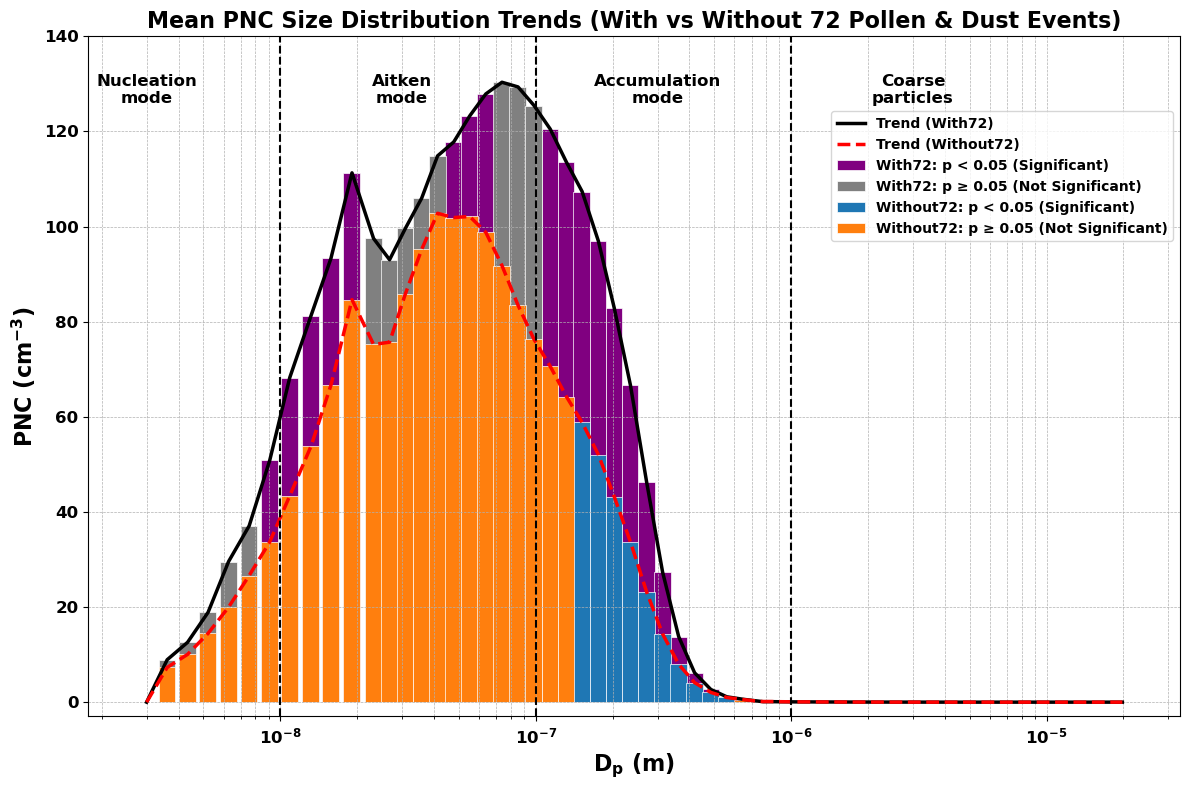

In [5]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====
def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def effective_sample_size(x, nlags=12):
    """Calculate effective sample size while avoiding division by zero warnings."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2 or np.all(x == x.iloc[0]):  # constant or too short series
        return 1
    try:
        acfs = acf(x, nlags=nlags, fft=True)[1:]
        ess = n / (1 + 2 * np.sum(acfs))
        return max(ess, 1)
    except Exception:
        return 1

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

def process_file(file_path):
    """Load and process a file, return trend_df using MEAN instead of median"""
    df = pd.read_excel(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # ==== Monthly resampling using MEAN ====
    resampled = df.resample('M').mean()
    resampled_low = df.resample('M').quantile(0.25)
    resampled_up = df.resample('M').quantile(0.75)

    # X for regression
    x_dates = resampled.index
    x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
    x_num = x_num.to_numpy()

    trend_stats = []
    for col in resampled.columns:
        y_main = resampled[col]
        y_low = resampled_low[col]
        y_up = resampled_up[col]

        mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
        if np.sum(mask) < 12:
            continue

        x_num_masked = x_num[mask]
        y_vals = y_main[mask].to_numpy(dtype='float64')

        try:
            tau, p_value = modified_mk_test(x_num_masked, y_vals)
            slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
            slope_unc = (slope_hi - slope_lo) / 2
            mean_y = np.mean(y_vals)
            slope_yr = slope * 365.25
            slope_unc_yr = slope_unc * 365.25
            rel_trend = (slope_yr / abs(mean_y)) * 100 if mean_y != 0 else 0
            rel_unc = (slope_unc_yr / abs(mean_y)) * 100 if mean_y != 0 else 0

            trend_stats.append({
                'Bin': float(col),
                'PNC': mean_y,
                'Slope (unit/yr)': slope_yr,
                '± Slope Uncertainty': slope_unc_yr,
                'Relative Trend (%/yr)': rel_trend,
                '± Relative Uncertainty': rel_unc,
                'p-value': p_value
            })
        except Exception:
            continue

    return pd.DataFrame(trend_stats)

# ==== File paths ====
file_with72 = '/Users/touqeergill/Desktop/10. PNC 72 Pollen and dust events.xlsx'
file_without72 = '/Users/touqeergill/Desktop/10. PNC Without 72 Pollen and dust events.xlsx'

# ==== Process both datasets ====
trend_df_with72 = process_file(file_with72)
trend_df_without72 = process_file(file_without72)

# ==== Extract data ====
particle_sizes = trend_df_with72['Bin'].to_numpy()

pnc_with72 = trend_df_with72['PNC'].to_numpy()
p_with72 = trend_df_with72['p-value'].to_numpy()
sig_with72 = p_with72 < 0.05
nonsig_with72 = ~sig_with72

pnc_without72 = trend_df_without72['PNC'].to_numpy()
p_without72 = trend_df_without72['p-value'].to_numpy()
sig_without72 = p_without72 < 0.05
nonsig_without72 = ~sig_without72

# ==== Colors ====
pval_colors = {
    'with_sig': '#800080',       # Purple for With72: p < 0.05
    'with_nonsig': '#808080',    # Grey for With72: p ≥ 0.05
    'without_sig': '#1f77b4',    # Blue for Without72: p < 0.05
    'without_nonsig': '#ff7f0e'  # Orange for Without72: p ≥ 0.05
}

# ==== Plot ====
fig, ax = plt.subplots(figsize=(12, 8))

# Bars: With72
bar_width = particle_sizes * 0.15
ax.bar(particle_sizes[sig_with72], pnc_with72[sig_with72],
       width=bar_width[sig_with72], color=pval_colors['with_sig'],
       edgecolor='white', linewidth=0.5, label='With72: p < 0.05 (Significant)')
ax.bar(particle_sizes[nonsig_with72], pnc_with72[nonsig_with72],
       width=bar_width[nonsig_with72], color=pval_colors['with_nonsig'],
       edgecolor='white', linewidth=0.5, label='With72: p ≥ 0.05 (Not Significant)')

# Bars: Without72
ax.bar(particle_sizes[sig_without72], pnc_without72[sig_without72],
       width=bar_width[sig_without72], color=pval_colors['without_sig'],
       edgecolor='white', linewidth=0.5, label='Without72: p < 0.05 (Significant)')
ax.bar(particle_sizes[nonsig_without72], pnc_without72[nonsig_without72],
       width=bar_width[nonsig_without72], color=pval_colors['without_nonsig'],
       edgecolor='white', linewidth=0.5, label='Without72: p ≥ 0.05 (Not Significant)')

# Trend lines
ax.plot(particle_sizes, pnc_with72, color='black', linewidth=2.5, label='Trend (With72)')
ax.plot(particle_sizes, pnc_without72, color='red', linestyle='--', linewidth=2.5, label='Trend (Without72)')

# ==== Y-axis range (adjustable) ====
y_min = -3
y_max = 140
ax.set_ylim(y_min, y_max)

# Formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax.set_ylabel(r'$\mathbf{PNC\ (cm^{\mathbf{-3}})}$', fontsize=16)
ax.set_title('Mean PNC Size Distribution Trends (With vs Without 72 Pollen & Dust Events)', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Mode boundaries
for boundary in [1e-8, 1e-7, 1e-6]:
    ax.axvline(x=boundary, color='black', linestyle='--')

# Mode labels
y_label_pos = y_max * 0.90
ax.text(3e-9, y_label_pos, 'Nucleation\nmode', fontsize=12, fontweight='bold', ha='center')
ax.text(3e-8, y_label_pos, 'Aitken\nmode', fontsize=12, fontweight='bold', ha='center')
ax.text(3e-7, y_label_pos, 'Accumulation\nmode', fontsize=12, fontweight='bold', ha='center')
ax.text(3e-6, y_label_pos, 'Coarse\nparticles', fontsize=12, fontweight='bold', ha='center')

# Legend
ax.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.90), prop={'weight': 'bold'})

# Ticks bold
ax.tick_params(axis='both', labelsize=12)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

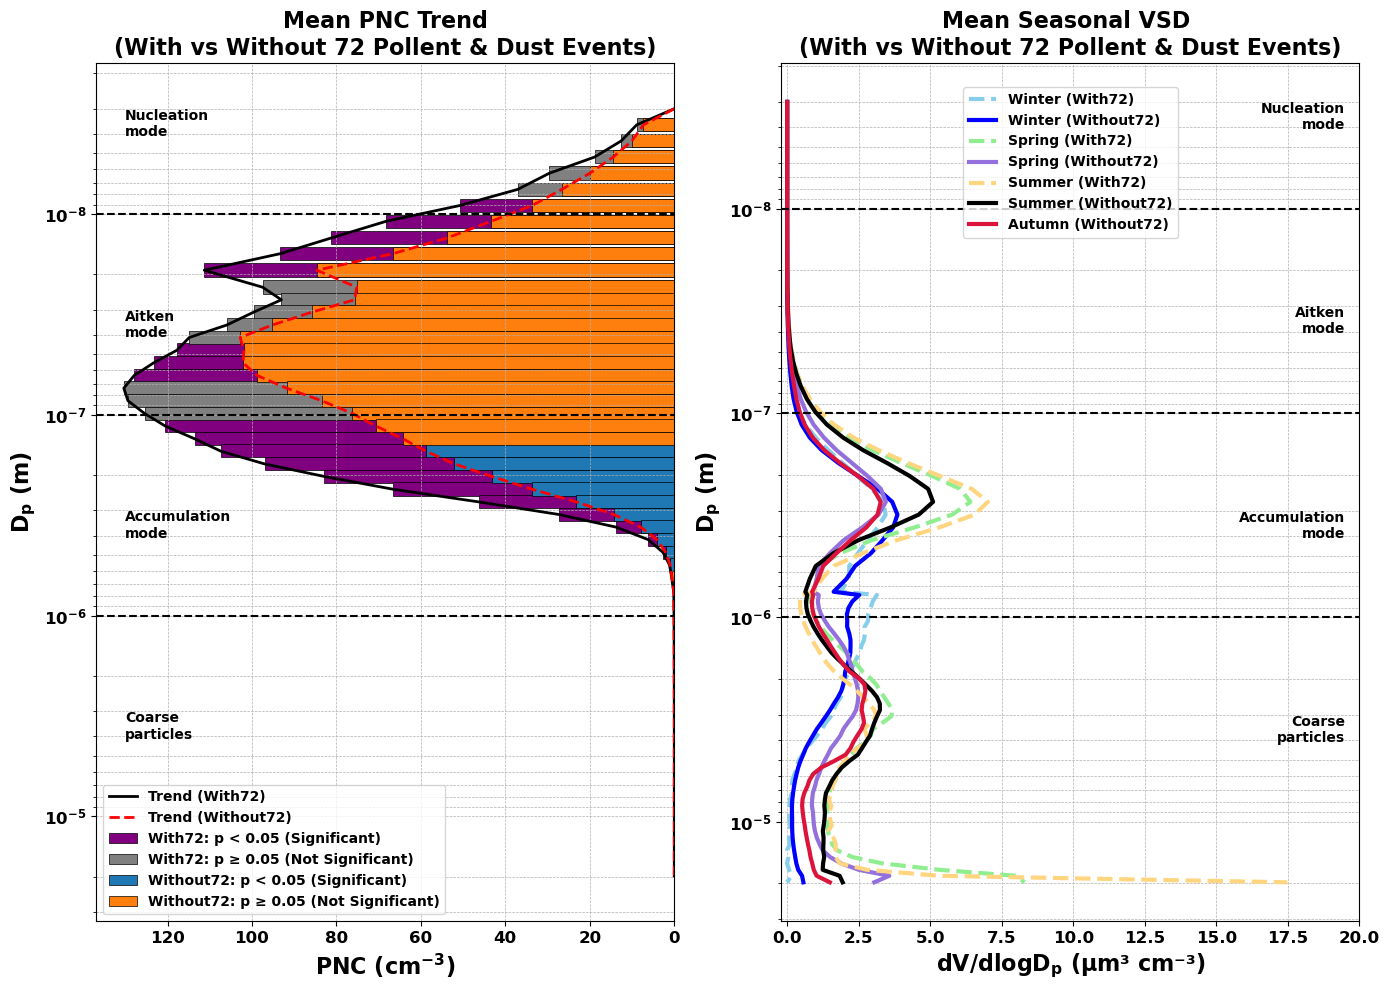

In [6]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====
def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def effective_sample_size(x, nlags=12):
    """Calculate effective sample size while avoiding division by zero warnings."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n < 2 or np.all(x == x.iloc[0]):  # constant or too short series
        return 1
    try:
        acfs = acf(x, nlags=nlags, fft=True)[1:]
        ess = n / (1 + 2 * np.sum(acfs))
        return max(ess, 1)
    except Exception:
        return 1

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

def process_file(file_path):
    """Load and process a file, return trend_df using MEAN"""
    df = pd.read_excel(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # ==== Monthly resampling using MEAN ====
    resampled = df.resample('M').mean()
    resampled_low = df.resample('M').quantile(0.25)
    resampled_up = df.resample('M').quantile(0.75)

    # X for regression
    x_dates = resampled.index
    x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
    x_num = x_num.to_numpy()

    trend_stats = []
    for col in resampled.columns:
        y_main = resampled[col]
        y_low = resampled_low[col]
        y_up = resampled_up[col]

        mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
        if np.sum(mask) < 12:
            continue

        x_num_masked = x_num[mask]
        y_vals = y_main[mask].to_numpy(dtype='float64')

        try:
            tau, p_value = modified_mk_test(x_num_masked, y_vals)
            slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
            slope_unc = (slope_hi - slope_lo) / 2
            mean_y = np.mean(y_vals)
            slope_yr = slope * 365.25
            slope_unc_yr = slope_unc * 365.25
            rel_trend = (slope_yr / abs(mean_y)) * 100 if mean_y != 0 else 0
            rel_unc = (slope_unc_yr / abs(mean_y)) * 100 if mean_y != 0 else 0

            trend_stats.append({
                'Bin': float(col),
                'PNC': mean_y,
                'Slope (unit/yr)': slope_yr,
                '± Slope Uncertainty': slope_unc_yr,
                'Relative Trend (%/yr)': rel_trend,
                '± Relative Uncertainty': rel_unc,
                'p-value': p_value
            })
        except Exception:
            continue

    return pd.DataFrame(trend_stats)

def process_event_data(file_path):
    """Process seasonal volume distributions"""
    df = pd.read_excel(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])

    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'

    df['Season'] = df['datetime'].dt.month.apply(get_season)
    diameter_cols = df.columns[1:-1]
    diameters_m = np.array([float(col) for col in diameter_cols])
    diameters_um = diameters_m * 1e6
    volume_factors = (np.pi / 6) * diameters_um**3
    volume_df = df[diameter_cols] * volume_factors
    volume_df['Season'] = df['Season']
    seasonal_means = volume_df.groupby('Season').mean()

    return diameters_m, seasonal_means

# ==== File paths ====
file_with72 = '/Users/touqeergill/Desktop/10. PNC 72 Pollen and dust events.xlsx'
file_without72 = '/Users/touqeergill/Desktop/10. PNC Without 72 Pollen and dust events.xlsx'
with72_file_vsd = '/Users/touqeergill/Desktop/10. 72 Pollen and dust events.xlsx'
without72_file_vsd = '/Users/touqeergill/Desktop/10. Without 72 Pollen and dust events.xlsx'

# ==== Process datasets ====
trend_df_with72 = process_file(file_with72)
trend_df_without72 = process_file(file_without72)

diameters_m_with72, seasonal_means_with72 = process_event_data(with72_file_vsd)
diameters_m_without72, seasonal_means_without72 = process_event_data(without72_file_vsd)

# ==== Extract data ====
particle_sizes = trend_df_with72['Bin'].to_numpy()
pnc_with72 = trend_df_with72['PNC'].to_numpy()
p_with72 = trend_df_with72['p-value'].to_numpy()
sig_with72 = p_with72 < 0.05
nonsig_with72 = ~sig_with72

pnc_without72 = trend_df_without72['PNC'].to_numpy()
p_without72 = trend_df_without72['p-value'].to_numpy()
sig_without72 = p_without72 < 0.05
nonsig_without72 = ~sig_without72

# ==== Colors ====
pval_colors = {
    'with_sig': '#800080',       # Purple for With72: p < 0.05
    'with_nonsig': '#808080',    # Grey for With72: p ≥ 0.05
    'without_sig': '#1f77b4',    # Blue for Without72: p < 0.05
    'without_nonsig': '#ff7f0e'  # Orange for Without72: p ≥ 0.05
}

season_colors_with = {
    'Winter': '#87CEEB',  # Sky Blue
    'Spring': '#90EE90',  # Light Green
    'Summer': '#FFD580',  # Light Orange
    'Autumn': '#FFB6C1'   # Light Pink
}
dark_season_colors_without = {
    'Winter': '#0000FF',
    'Spring': '#9370DB',
    'Summer': '#000000',
    'Autumn': '#DC143C'
}

# ==== Create the figure ====
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# === LEFT PLOT: PNC Trends === #
ax1 = axs[0]
bar_height = particle_sizes * 0.15

# Bars: With72
ax1.barh(particle_sizes[sig_with72], pnc_with72[sig_with72],
         height=bar_height[sig_with72], color=pval_colors['with_sig'],
         edgecolor='black', linewidth=0.5, label='With72: p < 0.05 (Significant)')
ax1.barh(particle_sizes[nonsig_with72], pnc_with72[nonsig_with72],
         height=bar_height[nonsig_with72], color=pval_colors['with_nonsig'],
         edgecolor='black', linewidth=0.5, label='With72: p ≥ 0.05 (Not Significant)')

# Bars: Without72
ax1.barh(particle_sizes[sig_without72], pnc_without72[sig_without72],
         height=bar_height[sig_without72], color=pval_colors['without_sig'],
         edgecolor='black', linewidth=0.5, label='Without72: p < 0.05 (Significant)')
ax1.barh(particle_sizes[nonsig_without72], pnc_without72[nonsig_without72],
         height=bar_height[nonsig_without72], color=pval_colors['without_nonsig'],
         edgecolor='black', linewidth=0.5, label='Without72: p ≥ 0.05 (Not Significant)')

# Trend lines
ax1.plot(pnc_with72, particle_sizes, color='black', linewidth=2.0, label='Trend (With72)')
ax1.plot(pnc_without72, particle_sizes, color='red', linestyle='--', linewidth=2.0, label='Trend (Without72)')

# Axes scaling
ax1.set_yscale('log')
ax1.set_ylim(ax1.get_ylim()[::-1])   # invert Dp axis
ax1.set_xlim(ax1.get_xlim()[::-1])   # invert PNC axis (0 → right, max → left)

ax1.set_xlabel(r'$\mathbf{PNC\ (cm^{-3})}$', fontsize=16, fontweight='bold')
ax1.set_ylabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax1.set_title('Mean PNC Trend\n(With vs Without 72 Pollent & Dust Events)', fontsize=16, fontweight='bold')

# Mode boundaries
for boundary in [1e-8, 1e-7, 1e-6]:
    ax1.axhline(y=boundary, color='black', linestyle='--')

# Mode labels
x_label_pos = ax1.get_xlim()[0] * 0.95
ax1.text(x_label_pos, 3e-9, 'Nucleation\nmode', fontsize=10, fontweight='bold', va='top', ha='left')
ax1.text(x_label_pos, 3e-8, 'Aitken\nmode', fontsize=10, fontweight='bold', va='top', ha='left')
ax1.text(x_label_pos, 3e-7, 'Accumulation\nmode', fontsize=10, fontweight='bold', va='top', ha='left')
ax1.text(x_label_pos, 3e-6, 'Coarse\nparticles', fontsize=10, fontweight='bold', va='top', ha='left')

ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
for tick in ax1.get_xticklabels() + ax1.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(12)
ax1.legend(fontsize=9, loc='lower left', prop={'weight': 'bold'})

# === RIGHT PLOT: Seasonal VSD === #
ax2 = axs[1]

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_means_with72.index:
        ax2.plot(seasonal_means_with72.loc[season], diameters_m_with72,
                 label=f'{season} (With72)', color=season_colors_with[season],
                 linestyle='--', linewidth=3)
    if season in seasonal_means_without72.index:
        ax2.plot(seasonal_means_without72.loc[season], diameters_m_without72,
                 label=f'{season} (Without72)', color=dark_season_colors_without[season],
                 linestyle='-', linewidth=3)

ax2.set_xlim(-0.2, 20)
ax2.set_yscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel(r'dV/dlog$\mathbf{D}_{\mathbf{p}}$ (µm³ cm⁻³)', fontsize=16, fontweight='bold')
ax2.set_ylabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax2.set_title('Mean Seasonal VSD \n(With vs Without 72 Pollent & Dust Events)', fontsize=16, fontweight='bold')

# Mode boundaries
for boundary in [1e-8, 1e-7, 1e-6]:
    ax2.axhline(y=boundary, color='black', linestyle='--')

# Mode labels
label_x_volume = ax2.get_xlim()[1] - 0.5
ax2.text(label_x_volume, 3e-9, 'Nucleation\nmode', fontsize=10, fontweight='bold', va='top', ha='right')
ax2.text(label_x_volume, 3e-8, 'Aitken\nmode', fontsize=10, fontweight='bold', va='top', ha='right')
ax2.text(label_x_volume, 3e-7, 'Accumulation\nmode', fontsize=10, fontweight='bold', va='top', ha='right')
ax2.text(label_x_volume, 3e-6, 'Coarse\nparticles', fontsize=10, fontweight='bold', va='top', ha='right')

ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(12)

# 🔹 Legend moved outside, vertically centered
ax2.legend(fontsize=9, loc='upper center', bbox_to_anchor=(0.5, 0.98), prop={'weight': 'bold'})

# ==== Final Layout ====
plt.tight_layout()
plt.show()

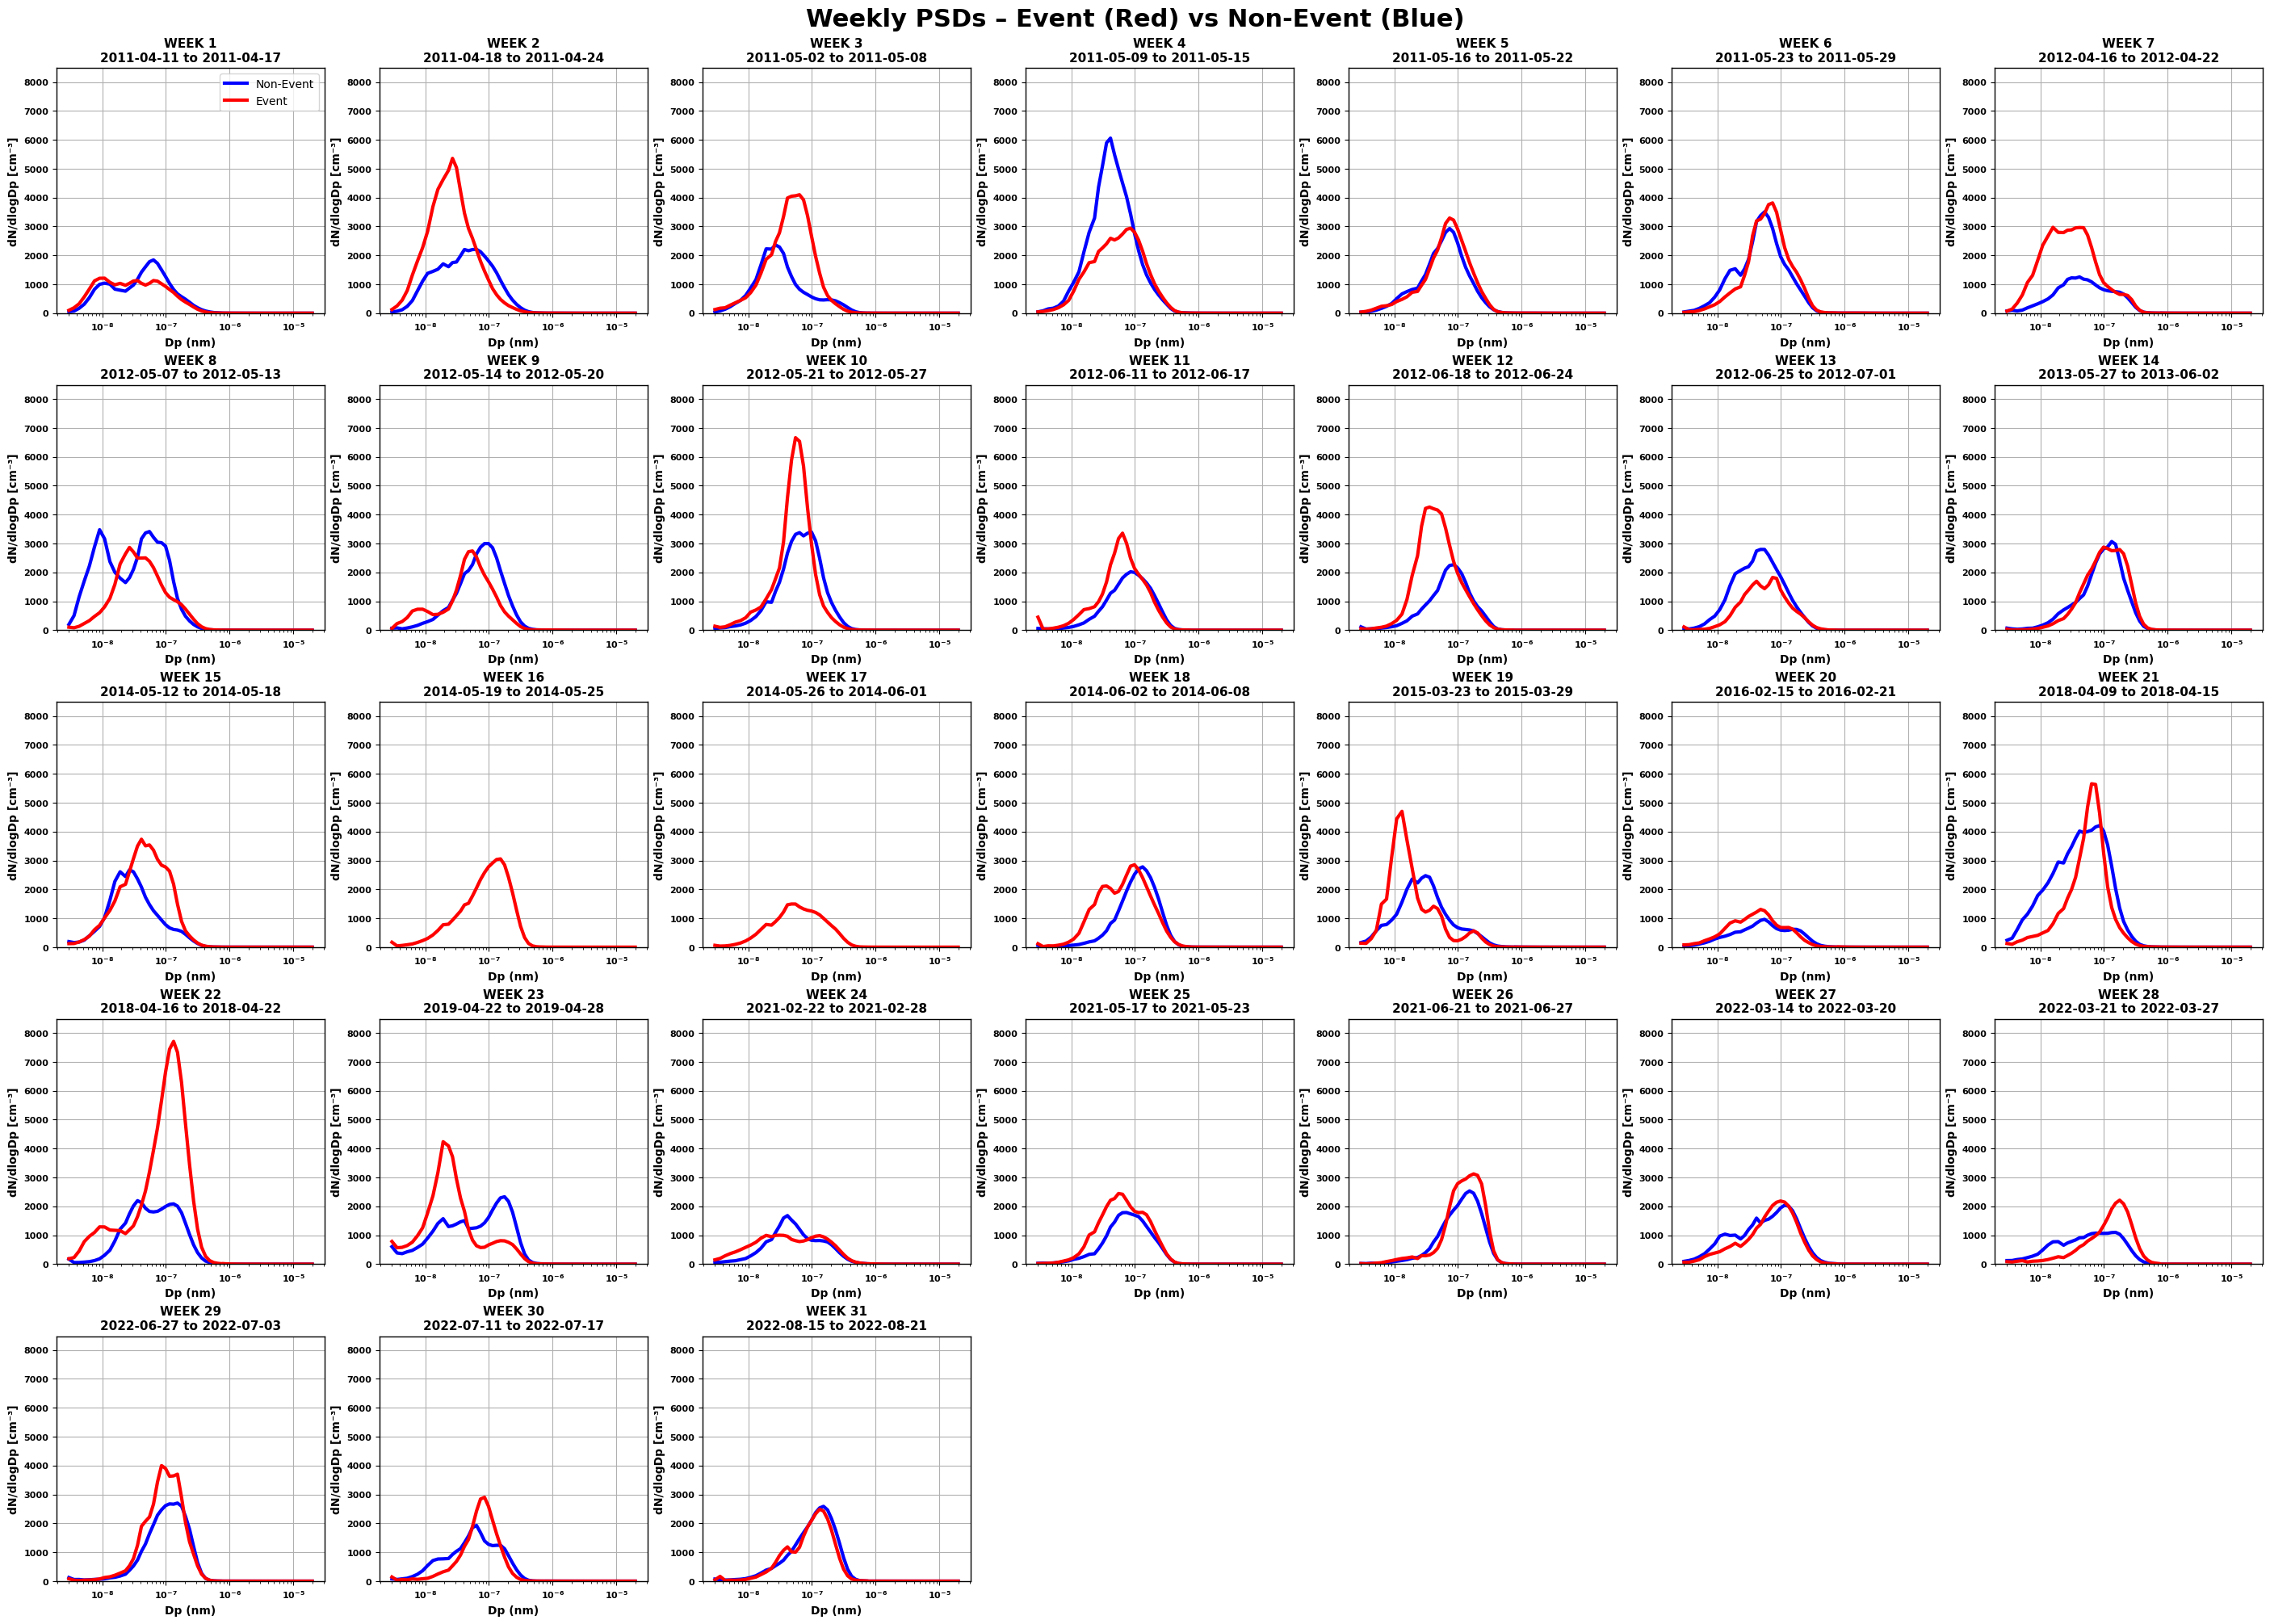

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Load the Excel File ===
file_path = '/Users/touqeergill/Desktop/Event + Non Event.xlsx'  # <- update if needed
event_df = pd.read_excel(file_path, sheet_name='EVENTS DAYS')
non_event_df = pd.read_excel(file_path, sheet_name='NON EVENT DAYS')

# === Step 2: Convert datetime and extract week start ===
event_df['datetime'] = pd.to_datetime(event_df['datetime'])
non_event_df['datetime'] = pd.to_datetime(non_event_df['datetime'])
event_df['week_start'] = event_df['datetime'].dt.to_period('W').apply(lambda r: r.start_time)
non_event_df['week_start'] = non_event_df['datetime'].dt.to_period('W').apply(lambda r: r.start_time)

# === Step 3: Use provided 31-week labels ===
custom_week_labels = [
    "2011-04-11 to 2011-04-17", "2011-04-18 to 2011-04-24", "2011-05-02 to 2011-05-08",
    "2011-05-09 to 2011-05-15", "2011-05-16 to 2011-05-22", "2011-05-23 to 2011-05-29",
    "2012-04-16 to 2012-04-22", "2012-05-07 to 2012-05-13", "2012-05-14 to 2012-05-20",
    "2012-05-21 to 2012-05-27", "2012-06-11 to 2012-06-17", "2012-06-18 to 2012-06-24",
    "2012-06-25 to 2012-07-01", "2013-05-27 to 2013-06-02", "2014-05-12 to 2014-05-18",
    "2014-05-19 to 2014-05-25", "2014-05-26 to 2014-06-01", "2014-06-02 to 2014-06-08",
    "2015-03-23 to 2015-03-29", "2016-02-15 to 2016-02-21", "2018-04-09 to 2018-04-15",
    "2018-04-16 to 2018-04-22", "2019-04-22 to 2019-04-28", "2021-02-22 to 2021-02-28",
    "2021-05-17 to 2021-05-23", "2021-06-21 to 2021-06-27", "2022-03-14 to 2022-03-20",
    "2022-03-21 to 2022-03-27", "2022-06-27 to 2022-07-03", "2022-07-11 to 2022-07-17",
    "2022-08-15 to 2022-08-21"
]
common_weeks = [pd.to_datetime(s.split(" to ")[0]) for s in custom_week_labels]

# === Step 4: Get particle diameter values ===
# Assumes columns are: ['datetime', <diameters...>, 'week_start']
diameters = event_df.columns[1:-1]  # Exclude 'datetime' and 'week_start'
diameters_float = [float(d) for d in diameters]

# === Step 5: Compute weekly means ===
event_weekly_means = []
non_event_weekly_means = []

for week_start in common_weeks:
    event_data = event_df[event_df['week_start'] == week_start].iloc[:, 1:-1]
    non_event_data = non_event_df[non_event_df['week_start'] == week_start].iloc[:, 1:-1]
    event_weekly_means.append(event_data.mean(numeric_only=True))
    non_event_weekly_means.append(non_event_data.mean(numeric_only=True))

# === Step 6: Determine global max for y-axis (robust to empty/all-NaN rows) ===
def safe_row_max(s):
    vals = np.asarray(s.values, dtype=float)
    if vals.size == 0 or np.isnan(vals).all():
        return np.nan
    return np.nanmax(vals)

event_maxes = [safe_row_max(e) for e in event_weekly_means]
nonevent_maxes = [safe_row_max(n) for n in non_event_weekly_means]
finite_maxes = [x for x in event_maxes + nonevent_maxes if np.isfinite(x)]
global_max_val = max(finite_maxes) if finite_maxes else 1.0  # sensible fallback

# === Step 7: Create Multi-Panel Plot ===
fig, axes = plt.subplots(5, 7, figsize=(28, 20), constrained_layout=True)
axes = axes.flatten()

for i, (label, event_row, non_event_row) in enumerate(zip(custom_week_labels, event_weekly_means, non_event_weekly_means)):
    ax = axes[i]

    # OPTIONAL: hide subplots where both series are all-NaN
    if np.isnan(event_maxes[i]) and np.isnan(nonevent_maxes[i]):
        ax.set_visible(False)
        continue

    # Plot
    ax.semilogx(diameters_float, non_event_row.values, color='blue', linewidth=3, label="Non-Event")
    ax.semilogx(diameters_float, event_row.values, color='red', linewidth=3, label="Event")

    # Title and labels — add WEEK number
    ax.set_title(f"WEEK {i+1}\n{label}", fontsize=11, weight='bold')

    # If you prefer a small "badge" instead of editing the title, comment the line above
    # and uncomment this block:
    # ax.set_title(label, fontsize=11, weight='bold')
    # ax.text(0.02, 0.95, f"WEEK {i+1}", transform=ax.transAxes,
    #         ha='left', va='top', fontsize=12, fontweight='bold',
    #         bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none'))

    ax.set_xlabel('Dp (nm)', fontsize=10, weight='bold')
    ax.set_ylabel('dN/dlogDp [cm⁻³]', fontsize=10, weight='bold')

    ax.set_ylim(0, global_max_val * 1.1)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=8)

    for label_obj in ax.get_xticklabels() + ax.get_yticklabels():
        label_obj.set_fontweight('bold')
    for spine in ax.spines.values():
        spine.set_linewidth(1)

# === Step 8: Hide unused axes (if any) ===
for j in range(len(custom_week_labels), len(axes)):
    fig.delaxes(axes[j])

# === Step 9: Shared legend ===
# Show legend only once to avoid clutter
axes[0].legend(fontsize=10)

# === Step 10: Super Title and Show ===
plt.suptitle('Weekly PSDs – Event (Red) vs Non-Event (Blue)', fontsize=22, weight='bold')
plt.show()